## <font color='red'>Import Library</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import math
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
from scipy import sparse
from IPython.display import display, HTML

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [2]:
# -----------------------------
# Reproducibility (Fix randomness)
# -----------------------------
# Ensures that results are repeatable every time the script is run
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# Load Dataset
# -----------------------------
df = pd.read_csv("../data/cleaned_audi.csv")

# -----------------------------
# Feature Configuration
# -----------------------------
target_col = 'selling_price'
numeric_cols = ['mileage', 'engine_size', 'tax', 'miles_per_litre', 'car_age']
categorical_cols = ['model', 'transmission_type', 'fuel_type']

LOG_TARGET = True  # we train on log1p(price) to reduce skewness and evaluate back in price space

y = df[target_col].astype(float)
y_model = np.log1p(y) if LOG_TARGET else y
X = df[numeric_cols + categorical_cols].copy()

In [3]:
# -----------------------------
# Preprocessing Pipeline
# -----------------------------

# Transform numeric features using log1p (to reduce skew) before scaling
log1p_transformer = FunctionTransformer(np.log1p, validate=False)

numeric_preprocess = Pipeline(steps=[
    ('log1p', log1p_transformer), # Apply log(1+x) to numeric columns
    ('scaler', StandardScaler()) # Standardize them (mean=0, std=1)
])

# Convert categorical features to one-hot vectors
categorical_preprocess = OneHotEncoder(handle_unknown='ignore', drop='first')

# Apply numeric + categorical preprocessing to the dataset
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocess, numeric_cols),
        ('cat', categorical_preprocess, categorical_cols),
    ],
    remainder='drop'
)

In [4]:
# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_model, test_size=0.2, random_state=42
)

In [5]:
# -----------------------------
# Helpers Functions
# -----------------------------

# Convert values back to original price scale (undo log1p if used)
def _to_price(true_or_pred, log_target=LOG_TARGET):
    return np.expm1(true_or_pred) if log_target else true_or_pred

# Compute performance metrics (MAE, MSE, RMSE, R²)
def eval_scores(y_true_price, y_pred_price):
    mae  = mean_absolute_error(y_true_price, y_pred_price)
    mse  = mean_squared_error(y_true_price, y_pred_price)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true_price, y_pred_price)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Scatter plot: Actual vs Predicted prices
def scatter_actual_vs_pred(y_true_price, y_pred_price, title):
    y_true_price = np.asarray(y_true_price).ravel()
    y_pred_price = np.asarray(y_pred_price).ravel()

    plt.figure(figsize=(7,6))
    sns.scatterplot(x=y_true_price, y=y_pred_price, alpha=0.6, edgecolor='k')

    # Perfect line (y=x)
    lo = min(y_true_price.min(), y_pred_price.min())
    hi = max(y_true_price.max(), y_pred_price.max())
    plt.plot([lo, hi], [lo, hi], 'r--', lw=2, label='Perfect Prediction (y = x)')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("Actual selling_price")
    plt.ylabel("Predicted selling_price")
    plt.title(title)
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Histogram of prediction residuals (prediction errors)
def residual_hist(y_true_price, y_pred_price, title):
    resid = y_pred_price - y_true_price  # Compute residuals
    plt.figure(figsize=(7,4))
    plt.hist(resid, bins=40)
    plt.title(f"Residuals (Pred - Actual) — {title}")
    plt.xlabel("Error")
    plt.ylabel("Count")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## <font color='red'>Linear Regression</font>

In [6]:
# -----------------------------
# LINEAR REGRESSION
# -----------------------------
pipe_lr = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LinearRegression())
])
pipe_lr.fit(X_train, y_train)

# -----------------------------
# Predictions (log -> price)
# -----------------------------
y_pred_lr_tr_log = pipe_lr.predict(X_train)
y_pred_lr_te_log = pipe_lr.predict(X_test)

# Back to price space for predictions
y_pred_lr_tr = _to_price(y_pred_lr_tr_log)
y_pred_lr_te = _to_price(y_pred_lr_te_log)

# Round predicted prices to 2 decimals
y_pred_lr_tr = np.round(y_pred_lr_tr, 2)
y_pred_lr_te = np.round(y_pred_lr_te, 2)

# Get ACTUAL prices EXACTLY from the original df
y_true_tr_price = np.round(df.loc[X_train.index, target_col].astype(float).values, 2)
y_true_te_price = np.round(df.loc[X_test.index,  target_col].astype(float).values, 2)

# =======================================
# SUMMARY OF ACTUAL & PREDICTED
# =======================================
test_full_all = df.loc[X_test.index].copy()   # all original columns
test_full_all['Actual Price'] = y_true_te_price
test_full_all['Predicted Price'] = y_pred_lr_te
test_full_all['Error'] = (test_full_all['Predicted Price'] - test_full_all['Actual Price']).round(2)
test_full_all['Absolute Error'] = test_full_all['Error'].abs().round(2)
test_full_all['Percent Error (%)'] = ((test_full_all['Absolute Error'] / test_full_all['Actual Price']) * 100).round(2)

print("\n=== Summary of Actual vs Predicted (Linear Regression) ===")
print(test_full_all.head(10))

# Save full table
test_full_all.to_csv("Actual vs Predicted (Linear Regression).csv", index=False)
print("\nSaved as: Actual vs Predicted (Linear Regression).csv")


=== Summary of Actual vs Predicted (Linear Regression) ===
     model  manufactured_year  selling_price transmission_type  mileage  \
3666    A1               2016          12691            Manual    14681   
2907    Q7               2019          47816         Semi-Auto    14915   
6749    A3               2019          21450            Manual     2800   
8062    Q3               2016          13849            Manual    46553   
3964    A3               2015          12990         Semi-Auto    27100   
4074    Q5               2019          45490         Automatic    10000   
318     Q5               2019          34985         Automatic     7573   
7371    Q5               2017          23990         Automatic    27000   
2036    A4               2015          14998            Manual    54654   
2595    A1               2017          12360            Manual     8773   

     fuel_type  tax  engine_size  car_age  miles_per_litre  Actual Price  \
3666    Petrol    0          1.0      

LR TRAIN | MAE=2,370.67  MSE=11,474,151.98  RMSE=3,387.35  R2=0.9159
LR  TEST | MAE=2,499.33  MSE=13,159,225.61  RMSE=3,627.56  R2=0.9070


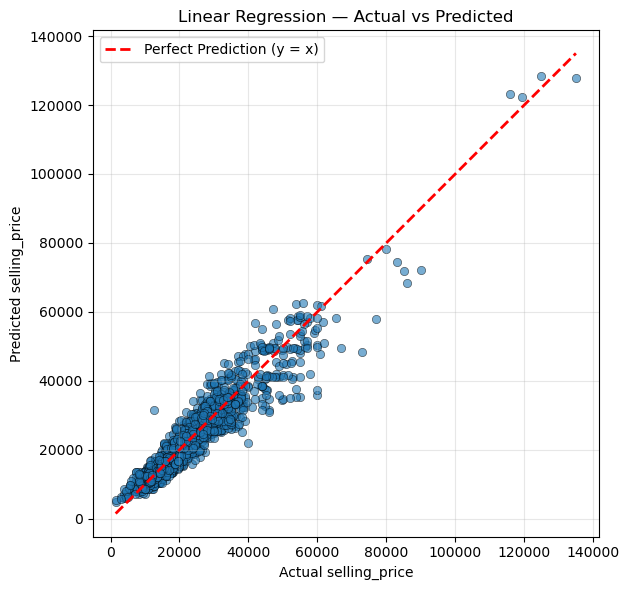

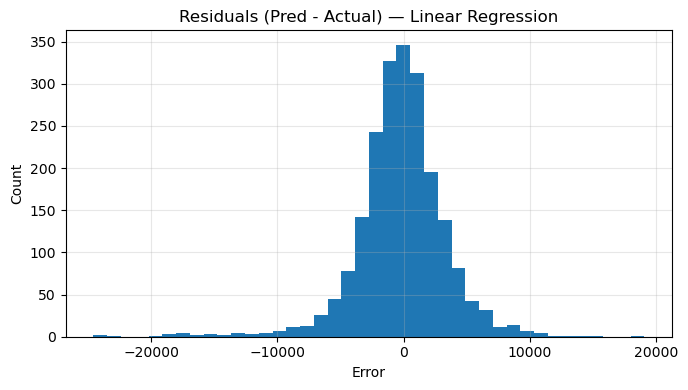

In [7]:
# -----------------------------
# Metrics (in price space)
# -----------------------------
lr_train = {'Model': 'Linear Regression — Train', **eval_scores(y_true_tr_price, y_pred_lr_tr)}
lr_test  = {'Model': 'Linear Regression — Test',  **eval_scores(y_true_te_price, y_pred_lr_te)}

print(f"LR TRAIN | MAE={lr_train['MAE']:,.2f}  MSE={lr_train['MSE']:,.2f}  RMSE={lr_train['RMSE']:,.2f}  R2={lr_train['R2']:.4f}")
print(f"LR  TEST | MAE={lr_test['MAE']:,.2f}  MSE={lr_test['MSE']:,.2f}  RMSE={lr_test['RMSE']:,.2f}  R2={lr_test['R2']:.4f}")

# -----------------------------
# Visual Diagnostics
# -----------------------------
scatter_actual_vs_pred(y_true_te_price, y_pred_lr_te, "Linear Regression — Actual vs Predicted")
residual_hist(y_true_te_price, y_pred_lr_te, "Linear Regression")

## <font color='red'>Deep Learning (MLP)</font>

In [9]:
# -----------------------------
# Deep Learning (MLP)
# -----------------------------

# Clone and fit the preprocessing pipeline for neural network input
preprocess_nn = clone(preprocess)
preprocess_nn.fit(X_train)

# Transform training and testing data
Xtr = preprocess_nn.transform(X_train)
Xte = preprocess_nn.transform(X_test)
if sparse.issparse(Xtr):
    Xtr = Xtr.toarray()
    Xte = Xte.toarray()

ytr = y_train.values if hasattr(y_train, "values") else y_train
yte = y_test.values if hasattr(y_test, "values") else y_test

inp_dim = Xtr.shape[1]

# Define a simple Multi-Layer Perceptron model
model = keras.Sequential([
    layers.Input(shape=(inp_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"), # relu (speed up learning, avoid vanishing gradient)
    layers.Dense(32, activation="relu"), 
    layers.Dense(1)  # predicts log1p(price) if LOG_TARGET=True
])

# Compile the model (Adam optimizer, MSE loss, MAE metric)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002),
              loss="mse", metrics=["mae"])

# Early stopping to prevent overfitting
callback = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Train the model with validation split
history = model.fit(
    Xtr, ytr,
    validation_split=0.1,
    epochs=120,
    batch_size=256,
    callbacks=[callback],
    verbose=1
)

Epoch 1/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 46.9601 - mae: 6.0797 - val_loss: 9.4894 - val_mae: 2.3617
Epoch 2/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8406 - mae: 1.5078 - val_loss: 2.0665 - val_mae: 1.1226
Epoch 3/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6518 - mae: 0.9956 - val_loss: 1.3153 - val_mae: 0.8905
Epoch 4/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1518 - mae: 0.8296 - val_loss: 0.9657 - val_mae: 0.7536
Epoch 5/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8386 - mae: 0.6981 - val_loss: 0.7028 - val_mae: 0.6278
Epoch 6/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6156 - mae: 0.5856 - val_loss: 0.5324 - val_mae: 0.5272
Epoch 7/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4668 - mae: 0.4995 - val_loss: 0.4184 - val_mae: 0.4581
Epoch 8/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3628 - mae: 0.4333 - val_loss: 0.3309 - val_mae: 0.4023
Epoch 9/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2

MLP TRAIN | MAE=1,638.43  MSE=6,108,822.13  RMSE=2,471.60  R2=0.9552
MLP  TEST | MAE=1,977.81  MSE=17,260,122.48  RMSE=4,154.53  R2=0.8780


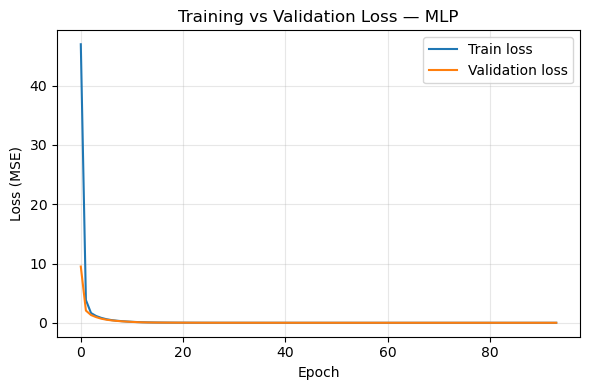


=== Summary of Actual vs Predicted (MLP) ===
     model  manufactured_year  selling_price transmission_type  mileage  \
3666    A1               2016          12691            Manual    14681   
2907    Q7               2019          47816         Semi-Auto    14915   
6749    A3               2019          21450            Manual     2800   
8062    Q3               2016          13849            Manual    46553   
3964    A3               2015          12990         Semi-Auto    27100   
4074    Q5               2019          45490         Automatic    10000   
318     Q5               2019          34985         Automatic     7573   
7371    Q5               2017          23990         Automatic    27000   
2036    A4               2015          14998            Manual    54654   
2595    A1               2017          12360            Manual     8773   

     fuel_type  tax  engine_size  car_age  miles_per_litre  Actual Price  \
3666    Petrol    0          1.0        9           

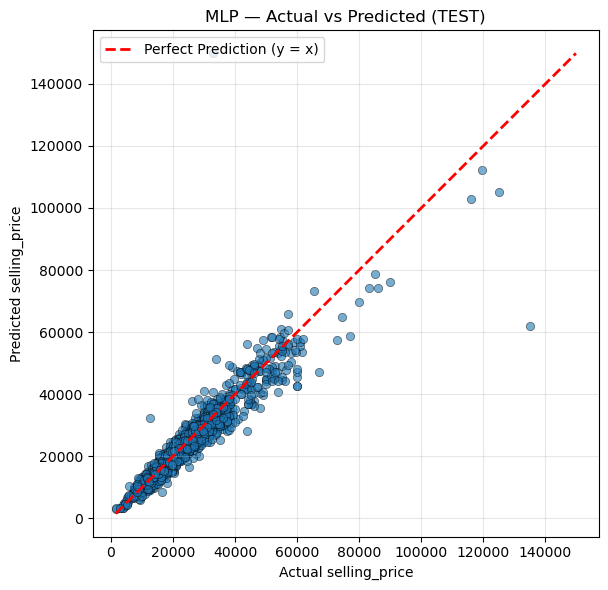

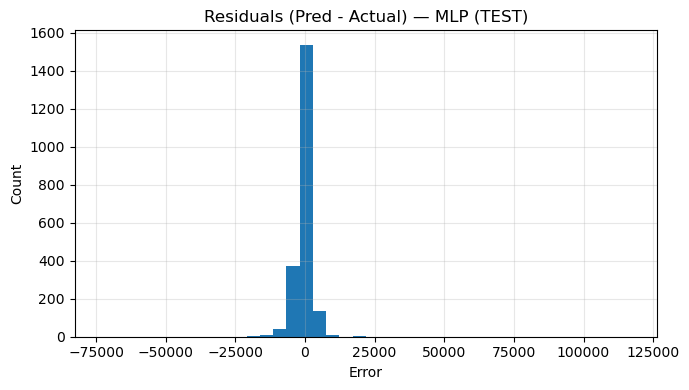

In [10]:
# -----------------------------
# MLP Predictions (log → price)
# -----------------------------
# Predict on train & test (still in log space)
pred_mlp_tr_log = model.predict(Xtr, verbose=0).ravel()
pred_mlp_te_log = model.predict(Xte, verbose=0).ravel()

# Convert predictions back to actual price scale
y_pred_mlp_tr = _to_price(pred_mlp_tr_log)
y_pred_mlp_te = _to_price(pred_mlp_te_log)

# Evaluate performance (in price space)
mlp_train = {'Model': 'MLP — Train', **eval_scores(y_true_tr_price, y_pred_mlp_tr)}
mlp_test  = {'Model': 'MLP — Test',  **eval_scores(y_true_te_price, y_pred_mlp_te)}

print(f"MLP TRAIN | MAE={mlp_train['MAE']:,.2f}  MSE={mlp_train['MSE']:,.2f}  RMSE={mlp_train['RMSE']:,.2f}  R2={mlp_train['R2']:.4f}")
print(f"MLP  TEST | MAE={mlp_test['MAE']:,.2f}  MSE={mlp_test['MSE']:,.2f}  RMSE={mlp_test['RMSE']:,.2f}  R2={mlp_test['R2']:.4f}")

# -----------------------------
# Loss Curve (Training vs Validation)
# ----------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch"); plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss — MLP")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# =======================================
# SUMMARY OF ACTUAL & PREDICTED — MLP (TEST)
# =======================================

# keep all original columns for context
mlp_summary = df.loc[X_test.index].copy()

# Add actual & predicted price and error metrics columns
mlp_summary['Actual Price'] = np.round(y_true_te_price, 2)
mlp_summary['Predicted Price'] = np.round(y_pred_mlp_te, 2)
mlp_summary['Error'] = (mlp_summary['Predicted Price'] - mlp_summary['Actual Price']).round(2)
mlp_summary['Absolute Error'] = mlp_summary['Error'].abs().round(2)

# Guard against divide-by-zero when actual price is 0
with np.errstate(divide='ignore', invalid='ignore'):
    pct_err = (mlp_summary['Absolute Error'] / mlp_summary['Actual Price']) * 100
mlp_summary['Percent Error (%)'] = np.round(np.where(np.isfinite(pct_err), pct_err, np.nan), 2)

# Show first 10 rows for inspection
print("\n=== Summary of Actual vs Predicted (MLP) ===")
print(mlp_summary.head(10))

# Save full table
csv_name = "Actual vs Predicted (MLP).csv"
mlp_summary.to_csv(csv_name, index=False, encoding="utf-8")
print(f"\nSaved as: {csv_name}")

# -----------------------------
# Visual Diagnostics (Test Set)
# -----------------------------
scatter_actual_vs_pred(y_true_te_price, y_pred_mlp_te, "MLP — Actual vs Predicted (TEST)")
residual_hist(y_true_te_price, y_pred_mlp_te, "MLP (TEST)")

In [11]:
# -----------------------------
# Compare Linear Regression vs MLP (Price Space) — Formatted
# -----------------------------
comparison = pd.DataFrame([
    lr_train,
    lr_test,
    mlp_train,
    mlp_test
])

# Round & format for display consistency
comparison_fmt = comparison.copy()
comparison_fmt["MAE"]  = comparison_fmt["MAE"].round(2)
comparison_fmt["MSE"]  = comparison_fmt["MSE"].round(2)
comparison_fmt["RMSE"] = comparison_fmt["RMSE"].round(2)
comparison_fmt["R2"]   = comparison_fmt["R2"].round(4)

print("\n=== Performance Comparison (LR vs MLP) ===")
print(comparison_fmt.to_string(index=False))

# Determine best model based on TEST performance
test_rows = comparison_fmt[comparison_fmt["Model"].str.contains("Test", case=False)]

best_mae_model  = test_rows.loc[test_rows["MAE"].idxmin(),  "Model"]
best_mse_model  = test_rows.loc[test_rows["MSE"].idxmin(),  "Model"]
best_rmse_model = test_rows.loc[test_rows["RMSE"].idxmin(), "Model"]
best_r2_model   = test_rows.loc[test_rows["R2"].idxmax(),   "Model"]

print("\n=== Best Model ===")
print(f"Lowest MAE  →  {best_mae_model}")
print(f"Lowest MSE  →  {best_mse_model}")
print(f"Lowest RMSE →  {best_rmse_model}")
print(f"Highest R²  →  {best_r2_model}")


=== Performance Comparison (LR vs MLP) ===
                    Model     MAE         MSE    RMSE     R2
Linear Regression — Train 2370.67 11474151.98 3387.35 0.9159
 Linear Regression — Test 2499.33 13159225.61 3627.56 0.9070
              MLP — Train 1638.43  6108822.13 2471.60 0.9552
               MLP — Test 1977.81 17260122.48 4154.53 0.8780

=== Best Model ===
Lowest MAE  →  MLP — Test
Lowest MSE  →  Linear Regression — Test
Lowest RMSE →  Linear Regression — Test
Highest R²  →  Linear Regression — Test


## <font color='red'>Ensemble (Blend - LR + MLP)</font>

Ensemble TRAIN | MAE=1,671.72  MSE=5,975,866.04  RMSE=2,444.56  R2=0.9562
Ensemble  TEST | MAE=1,941.25  MSE=11,950,210.48  RMSE=3,456.91  R2=0.9156

=== Summary of Actual vs Predicted (Ensemble LR+MLP) ===
     model  manufactured_year  selling_price transmission_type  mileage  \
3666    A1               2016          12691            Manual    14681   
2907    Q7               2019          47816         Semi-Auto    14915   
6749    A3               2019          21450            Manual     2800   
8062    Q3               2016          13849            Manual    46553   
3964    A3               2015          12990         Semi-Auto    27100   
4074    Q5               2019          45490         Automatic    10000   
318     Q5               2019          34985         Automatic     7573   
7371    Q5               2017          23990         Automatic    27000   
2036    A4               2015          14998            Manual    54654   
2595    A1               2017          1236

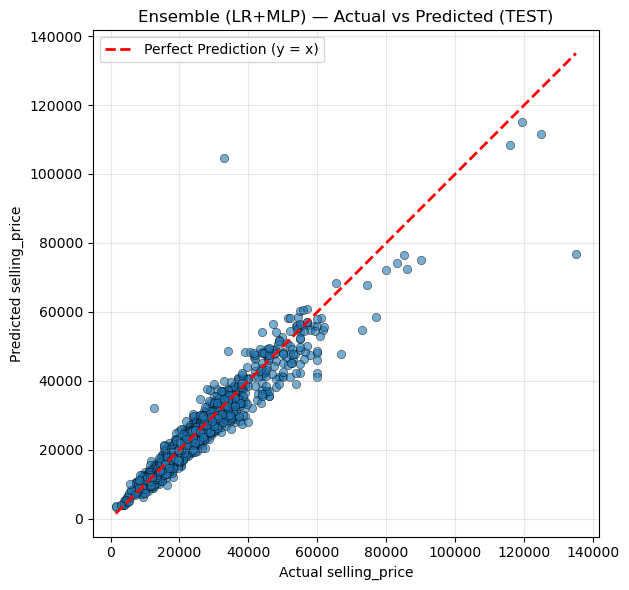

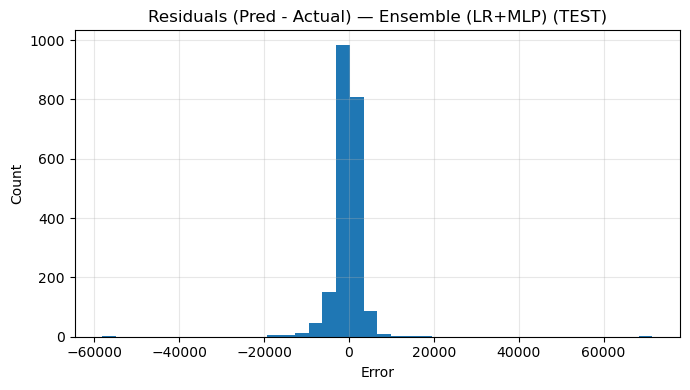

In [12]:
# -----------------------------
# Ensemble - Blend
# -----------------------------

# Set blend weights (MLP gets more because better)
W_LR, W_MLP = 0.3, 0.7

# Blend predictions in log space
blend_tr_log = W_LR*y_pred_lr_tr_log + W_MLP*pred_mlp_tr_log
blend_te_log = W_LR*y_pred_lr_te_log + W_MLP*pred_mlp_te_log

# Convert blended predictions back to price space
y_pred_bl_tr = _to_price(blend_tr_log)
y_pred_bl_te = _to_price(blend_te_log)

# Evaluate ensemble performance metrics
bl_train = {'Model': 'Ensemble (LR+MLP) — Train', **eval_scores(y_true_tr_price, y_pred_bl_tr)}
bl_test  = {'Model': 'Ensemble (LR+MLP) — Test',  **eval_scores(y_true_te_price, y_pred_bl_te)}

print(f"Ensemble TRAIN | MAE={bl_train['MAE']:,.2f}  MSE={bl_train['MSE']:,.2f}  RMSE={bl_train['RMSE']:,.2f}  R2={bl_train['R2']:.4f}")
print(f"Ensemble  TEST | MAE={bl_test['MAE']:,.2f}  MSE={bl_test['MSE']:,.2f}  RMSE={bl_test['RMSE']:,.2f}  R2={bl_test['R2']:.4f}")

# =======================================
# SUMMARY OF ACTUAL & PREDICTED — ENSEMBLE (TEST)
# =======================================

# keep original columns for context
ens_summary = df.loc[X_test.index].copy()

# Add actual & predicted price along with error metrics columns
ens_summary['Actual Price']    = np.round(y_true_te_price, 2)
ens_summary['Predicted Price'] = np.round(y_pred_bl_te, 2)
ens_summary['Error']           = (ens_summary['Predicted Price'] - ens_summary['Actual Price']).round(2)
ens_summary['Absolute Error']  = ens_summary['Error'].abs().round(2)

# Guard against divide-by-zero when Actual=0
with np.errstate(divide='ignore', invalid='ignore'):
    pct_err = (ens_summary['Absolute Error'] / ens_summary['Actual Price']) * 100
ens_summary['Percent Error (%)'] = np.round(np.where(np.isfinite(pct_err), pct_err, np.nan), 2)

print("\n=== Summary of Actual vs Predicted (Ensemble LR+MLP) ===")
print(ens_summary.head(10))

# Save full table
csv_name_ens = "Actual vs Predicted (Ensemble LR+MLP).csv"
ens_summary.to_csv(csv_name_ens, index=False, encoding="utf-8")
print(f"\nSaved as: {csv_name_ens}")

# -----------------------------
# Visual Diagnostics — Ensemble (TEST)
# -----------------------------
scatter_actual_vs_pred(y_true_te_price, y_pred_bl_te, "Ensemble (LR+MLP) — Actual vs Predicted (TEST)")
residual_hist(y_true_te_price, y_pred_bl_te, "Ensemble (LR+MLP) (TEST)")

### <font color='blue'>- Performance Metrics Comparison </font>

In [13]:
# -----------------------------
# Comparison tables
# -----------------------------
overall_df = pd.DataFrame([lr_train, lr_test, mlp_train, mlp_test, bl_train, bl_test])

pretty = overall_df.copy()
for c in ["MAE","MSE","RMSE"]:
    pretty[c] = pretty[c].apply(lambda x: f"{x:,.4f}")
pretty["R2"] = pretty["R2"].apply(lambda x: f"{x:.4f}")

print("\n=== Overall Performance Summary (Train & Test) ===")
display(HTML(pretty.to_html(index=False)))

# Test-only leaderboard
test_only = overall_df[overall_df["Model"].str.contains("— Test")].copy()
test_only["rank_MAE"]  = test_only["MAE"].rank(method="min", ascending=True)
test_only["rank_RMSE"] = test_only["RMSE"].rank(method="min", ascending=True)
test_only["rank_MSE"]  = test_only["MSE"].rank(method="min", ascending=True)
test_only["rank_R2"]   = test_only["R2"].rank(method="min", ascending=False)
test_only["overall_rank_sum"] = test_only[["rank_MAE","rank_RMSE","rank_MSE","rank_R2"]].sum(axis=1)

leader = test_only.sort_values(by=["overall_rank_sum","MAE"]).copy()
leader_pretty = leader[["Model","MAE","MSE","RMSE","R2","rank_MAE","rank_RMSE","rank_MSE","rank_R2","overall_rank_sum"]].copy()
for c in ["MAE","MSE","RMSE"]:
    leader_pretty[c] = leader_pretty[c].apply(lambda x: f"{x:,.4f}")

leader_pretty = leader[["Model","MAE","MSE","RMSE","R2","rank_MAE","rank_RMSE","rank_MSE","rank_R2","overall_rank_sum"]].copy()
for c in ["MAE","MSE","RMSE"]:
    leader_pretty[c] = leader_pretty[c].apply(lambda x: f"{x:,.4f}")
leader_pretty["R2"] = leader_pretty["R2"].apply(lambda x: f"{x:.4f}")

print("\n=== Test-only Leaderboard (lower rank sum is better) ===")
display(HTML(leader_pretty.to_html(index=False)))

# Print winners by metric (TEST)
best_mae_row  = test_only.loc[test_only["MAE"].idxmin()]
best_rmse_row = test_only.loc[test_only["RMSE"].idxmin()]
best_r2_row   = test_only.loc[test_only["R2"].idxmax()]

print("\nWinners (Test Set):")
print(f"• Lowest MAE : {best_mae_row['Model']}  ({best_mae_row['MAE']:.2f})")
print(f"• Lowest RMSE: {best_rmse_row['Model']}  ({best_rmse_row['RMSE']:.2f})")
print(f"• Highest R² : {best_r2_row['Model']}   ({best_r2_row['R2']:.4f})")


=== Overall Performance Summary (Train & Test) ===


Model,MAE,MSE,RMSE,R2
Linear Regression — Train,"2,370.6663","11,474,151.9845","3,387.3518",0.9159
Linear Regression — Test,"2,499.3315","13,159,225.6094","3,627.5647",0.9070
MLP — Train,"1,638.4290","6,108,822.1259","2,471.6031",0.9552
MLP — Test,"1,977.8131","17,260,122.4752","4,154.5304",0.8780
Ensemble (LR+MLP) — Train,"1,671.7158","5,975,866.0407","2,444.5585",0.9562
Ensemble (LR+MLP) — Test,"1,941.2545","11,950,210.4757","3,456.9076",0.9156



=== Test-only Leaderboard (lower rank sum is better) ===


Model,MAE,MSE,RMSE,R2,rank_MAE,rank_RMSE,rank_MSE,rank_R2,overall_rank_sum
Ensemble (LR+MLP) — Test,"1,941.2545","11,950,210.4757","3,456.9076",0.9156,1.0,1.0,1.0,1.0,4.0
Linear Regression — Test,"2,499.3315","13,159,225.6094","3,627.5647",0.9070,3.0,2.0,2.0,2.0,9.0
MLP — Test,"1,977.8131","17,260,122.4752","4,154.5304",0.8780,2.0,3.0,3.0,3.0,11.0



Winners (Test Set):
• Lowest MAE : Ensemble (LR+MLP) — Test  (1941.25)
• Lowest RMSE: Ensemble (LR+MLP) — Test  (3456.91)
• Highest R² : Ensemble (LR+MLP) — Test   (0.9156)


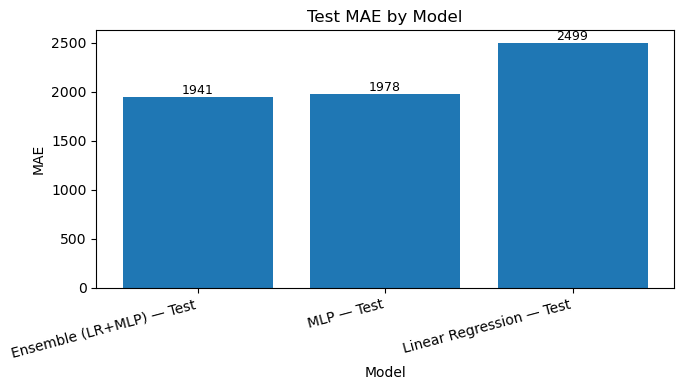

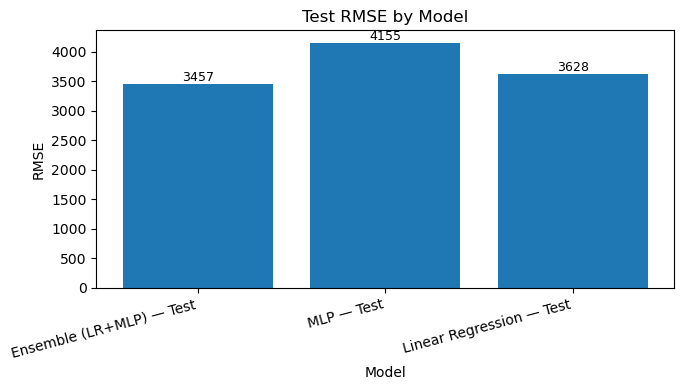

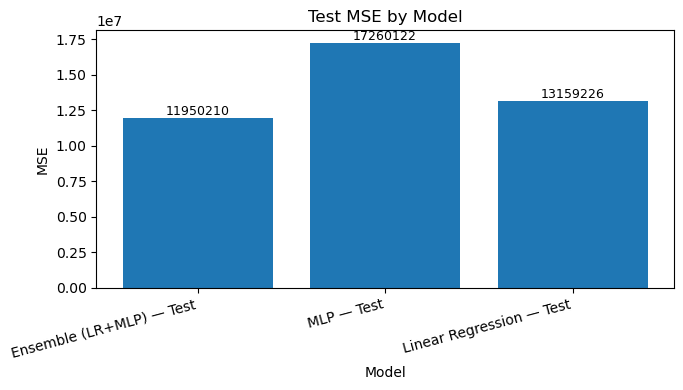

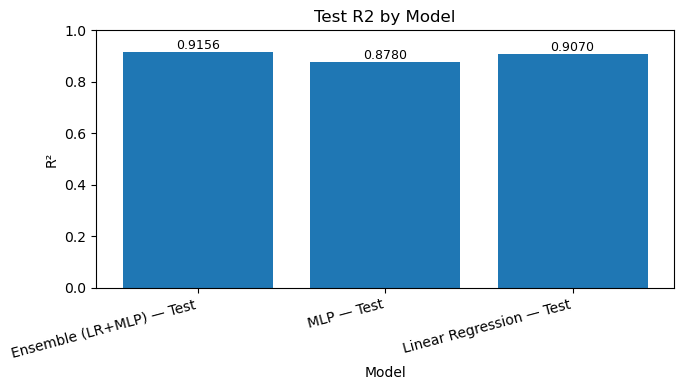

In [14]:
# -----------------------------
# Visualize each model metrics
# -----------------------------

# keep only test rows
test_df = overall_df[overall_df["Model"].str.contains("— Test")].copy()

# sort best-to-worst by MAE for readable order
test_df = test_df.sort_values("MAE")

def plot_metric(df, metric, ylabel=None, fmt="{:.0f}", ylim=None):
    plt.figure(figsize=(7,4))
    ax = plt.gca()
    ax.bar(df["Model"], df[metric])
    ax.set_title(f"Test {metric} by Model")
    ax.set_xlabel("Model")
    ax.set_ylabel(ylabel or metric)
    plt.xticks(rotation=15, ha="right")
    for bar in ax.patches:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, fmt.format(h),
                ha="center", va="bottom", fontsize=9)
    if ylim is not None:
        ax.set_ylim(*ylim)
    plt.tight_layout()
    plt.show()

plot_metric(test_df, "MAE",  "MAE",  fmt="{:.0f}")
plot_metric(test_df, "RMSE", "RMSE", fmt="{:.0f}")
plot_metric(test_df, "MSE",  "MSE",  fmt="{:.0f}")
plot_metric(test_df, "R2",   "R²",   fmt="{:.4f}", ylim=(0,1))

### <font color='blue'>- Permutation Importance</font>

In [15]:
# -----------------------------
# Permutation Importance
# -----------------------------
from collections import defaultdict

# --- Predictors that output in PRICE space ---
def _pred_lr_log(Xdf):
    return pipe_lr.predict(Xdf).ravel()

def _pred_mlp_log(Xdf):
    Xt = preprocess_nn.transform(Xdf)
    if sparse.issparse(Xt):
        Xt = Xt.toarray()
    return model.predict(Xt, verbose=0).ravel()

# Convert MLP log predictions → price
def _pred_lr_price(Xdf):
    return _to_price(_pred_lr_log(Xdf))

# Convert MLP log predictions → price
def _pred_mlp_price(Xdf):
    return _to_price(_pred_mlp_log(Xdf))

# Blend LR + MLP in log space, then convert → price
def _pred_ens_price(Xdf, w_lr=W_LR, w_mlp=W_MLP):
    ens_log = w_lr * _pred_lr_log(Xdf) + w_mlp * _pred_mlp_log(Xdf)
    return _to_price(ens_log)

def permutation_importance_r2(
    Xdf, y_true_price, predictor, n_repeats=8, random_state=42
):
    """
    Returns a DataFrame with columns:
      ['feature','r2_drop_mean','r2_drop_std','baseline_r2']
    r2_drop = baseline_R2 - shuffled_R2 (positive = more important).
    """
    rng = np.random.RandomState(random_state)
    Xdf = Xdf.copy()

    # Baseline R²
    y_pred_base = predictor(Xdf)
    baseline_r2 = r2_score(y_true_price, y_pred_base)

    drops = defaultdict(list)
    cols = list(Xdf.columns)
    
    # --- Shuffle ONE original feature at a time, multiple repeats ---
    for col in cols:
        for _ in range(n_repeats):
            X_perm = Xdf.copy()
            X_perm[col] = rng.permutation(X_perm[col].values)  # shuffle one original feature
            y_pred_perm = predictor(X_perm)
            r2_perm = r2_score(y_true_price, y_pred_perm)
            drops[col].append(baseline_r2 - r2_perm)  # positive drop => important

    # --- Aggregate mean/std drop per feature ---
    rows = []
    for col in cols:
        arr = np.asarray(drops[col], dtype=float)
        rows.append({
            "feature": col,
            "r2_drop_mean": float(arr.mean()),
            "r2_drop_std": float(arr.std(ddof=1) if len(arr) > 1 else 0.0),
            "baseline_r2": float(baseline_r2),
        })
        
    # Sort by importance (largest mean drop first)
    imp = pd.DataFrame(rows).sort_values("r2_drop_mean", ascending=False).reset_index(drop=True)
    return imp

# Compute permutation importance on TEST set for each model
pi_lr_r2 = permutation_importance_r2(X_test, y_true_te_price, _pred_lr_price,  n_repeats=8, random_state=42)
pi_mlp_r2 = permutation_importance_r2(X_test, y_true_te_price, _pred_mlp_price,  n_repeats=8, random_state=42)
pi_ens_r2 = permutation_importance_r2(X_test, y_true_te_price, _pred_ens_price, n_repeats=8, random_state=42)

pi_lr_r2["model"] = "Linear Regression (Test)"
pi_mlp_r2["model"] = "MLP (Test)"
pi_ens_r2["model"] = "Ensemble (Test)"

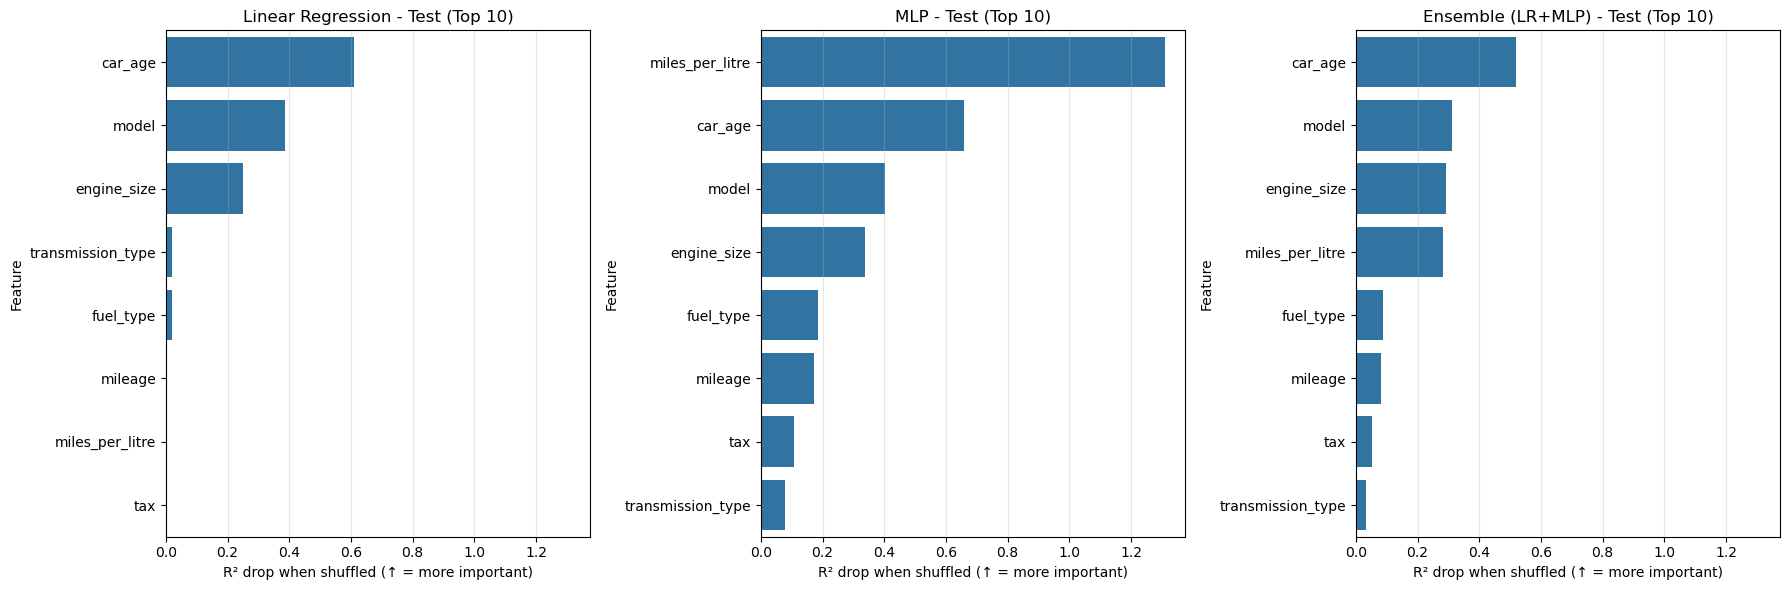


=== Permutation Importance — Linear Regression - Test ===


feature,r2_drop_mean,r2_drop_std,baseline_r2
car_age,0.608542,0.025770,0.907021
model,0.387668,0.014729,0.907021
engine_size,0.248474,0.007228,0.907021
transmission_type,0.020844,0.002733,0.907021
fuel_type,0.018664,0.001430,0.907021
mileage,0.003717,0.001852,0.907021
miles_per_litre,0.001928,0.000915,0.907021
tax,0.001552,0.000725,0.907021



=== Permutation Importance — MLP - Test ===


feature,r2_drop_mean,r2_drop_std,baseline_r2
miles_per_litre,1.309532,0.868617,0.878046
car_age,0.658588,0.369780,0.878046
model,0.402022,0.066947,0.878046
engine_size,0.339019,0.039585,0.878046
fuel_type,0.186215,0.017163,0.878046
mileage,0.171932,0.055683,0.878046
tax,0.107708,0.013837,0.878046
transmission_type,0.077237,0.017407,0.878046



=== Permutation Importance — Ensemble (LR+MLP) - Test ===


feature,r2_drop_mean,r2_drop_std,baseline_r2
car_age,0.519219,0.120940,0.915564
model,0.311164,0.020163,0.915564
engine_size,0.292552,0.018690,0.915564
miles_per_litre,0.282138,0.094285,0.915564
fuel_type,0.089077,0.008658,0.915564
mileage,0.080437,0.017219,0.915564
tax,0.050732,0.004600,0.915564
transmission_type,0.031673,0.004298,0.915564



=== OVERALL Top Features (Average R²-drop Across Models) ===


feature,overall_mean,overall_std
car_age,0.595450,0.070601
miles_per_litre,0.531199,0.688463
model,0.366951,0.048843
engine_size,0.293348,0.045277
fuel_type,0.097985,0.084130
mileage,0.085362,0.084216
tax,0.053330,0.053125
transmission_type,0.043252,0.029926


In [16]:
# -----------------------------
# Helpers for displaying top-N permutation importances
# -----------------------------

# Return top-N rows by mean R² drop, with selected columns
def _topn(df, n):
    return (df.sort_values("r2_drop_mean", ascending=False)
              .head(n)
              .reset_index(drop=True)
              [["feature","r2_drop_mean","r2_drop_std","baseline_r2","model"]])

def plot_perm_side_by_side(pi_list, labels, top_n=10):
    """
    pi_list: [pi_lr_r2, pi_mlp_r2, pi_ens_r2]
    labels : ["Linear Regression (Test)", "MLP (Test)", "Ensemble (Test)"]
    """

    # --- Create top-N for each model
    tops = []
    for df, name in zip(pi_list, labels):
        df = df.copy()
        df["model"] = name
        tops.append(_topn(df, top_n))

    # --- Side-by-side barplot (shared scale ensures comparability)
    x_max = max(t["r2_drop_mean"].max() for t in tops)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, top, name in zip(axes, tops, labels):
        sns.barplot(data=top, x="r2_drop_mean", y="feature", ax=ax)
        ax.set_xlabel("R² drop when shuffled (↑ = more important)")
        ax.set_ylabel("Feature")
        ax.set_title(f"{name} (Top {top_n})")
        ax.grid(axis="x", alpha=0.3)
        ax.set_xlim(0, x_max * 1.05)

    plt.tight_layout()
    plt.show()

    # --- Print the top-N tables for each model under the plot --- #
    for top, name in zip(tops, labels):
        print(f"\n=== Permutation Importance — {name} ===")
        display(HTML(top[["feature","r2_drop_mean","r2_drop_std","baseline_r2"]]
                     .to_html(index=False)))

    # --- Overall aggregated ranking across models --- #
    all_df = pd.concat([df.copy() for df in pi_list], ignore_index=True)

    overall = (all_df.groupby("feature", as_index=False)
                      .agg(overall_mean=("r2_drop_mean","mean"),
                           overall_std =("r2_drop_mean","std"))
                      .sort_values("overall_mean", ascending=False)
                      .head(top_n)
                      .reset_index(drop=True))

    print("\n=== OVERALL Top Features (Average R²-drop Across Models) ===")
    display(HTML(overall.to_html(index=False)))


# =====================================
# Call and display side by side comparison
# =====================================
plot_perm_side_by_side(
    [pi_lr_r2, pi_mlp_r2, pi_ens_r2],
    ["Linear Regression - Test", "MLP - Test", "Ensemble (LR+MLP) - Test"],
    top_n=10
)